In [1]:
#Test model on simulated data

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import os
import glob
import random

In [2]:

import config
import utils


In [3]:
#Read testing profiles and testing ground truth

groundTruthFilename = config.testProfilesDIR + config.groundTruthFileName

testGoals = open(groundTruthFilename)
lines = testGoals.readlines()
y_test = [l[:-1].split()[1:5] for l in lines[:-1]]
fileNames = [l[:-1].split()[0] for l in lines[:-1]]
testGoals.close()

fields = ['fields','fields10','fields30']
testProfiles3 = []
testProfiles10 = []
testProfiles30 = []

for fileName in fileNames:
    name = config.testProfilesDIR + fileName + '_' + fields[0] + '.npz'
    file = np.load(name)
    testProfiles3.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[1] + '.npz'
    file = np.load(name)
    testProfiles10.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[2] + '.npz'
    file = np.load(name)
    testProfiles30.append(file[file.files[1]])
        

testProfiles = []
testProfiles.append(testProfiles3)
testProfiles.append(testProfiles10)
testProfiles.append(testProfiles30)


In [4]:
# If some data from the regular training grid was left for testing then add it to the testing data

if config.FRACTION < 1.0:
    
    dataPoints = [(str(e),str(se),str(s),str(an)) for e in config.simulatedEnergies for se in config.simulatedEnergyDispersions for s in config.simulatedSourceSizes 
                  for an in config.simulatedAngularDivergences]

    random.seed(config.SEED)
    random.shuffle(dataPoints)

    profiles = utils.readProfiles(config.profileDIR,dataPoints)

    for field in range(3):
        for sample in range((int)(profiles[field].shape[0]*config.FRACTION),profiles[field].shape[0]):
            testProfiles[field].append(profiles[field][sample])    

    for point in dataPoints[(int)(len(dataPoints)*config.FRACTION):]:
        y_test.append(point)

testProfiles = np.asarray(testProfiles)
print(testProfiles.shape)

y_test = np.asarray(y_test,dtype=np.float)
print(y_test.shape)
    

(3, 25, 6, 495)
(25, 4)


In [5]:

# Read training means and subtract them from testing data

means = np.load(config.modelDIR + config.meansFileName)

diffTest = []
for field in range(3):
    diffTest.append(testProfiles[field] - np.stack([means[field] for _ in range(testProfiles[field].shape[0])]))



In [6]:

# Run PCA found for the training data on the testing data

from sklearn.decomposition import PCA
import pickle


testFeatures = []

for nfield,(field,Ranges) in enumerate(zip(config.analyzedProfiles,config.analyzedRanges)):
    if field != None:
        for profile,Range in zip(field,Ranges):
            print(nfield,profile)
            pcaName = config.modelDIR + 'PCA_' + str(nfield) + '_' + str(profile) + '_.pkl'
            pca = pickle.load(open(pcaName,'rb'))

            X = diffTest[nfield][:,profile,Range[0]:Range[1]]
            X_projected = pca.transform(X)
            testFeatures.append(X_projected)

X_test = np.stack(testFeatures)
X_test = np.swapaxes(X_test,1,0)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))  
print(X_test.shape)



1 0
1 1
1 3
2 0
2 1
2 3
(25, 18)


0.9819912096954254
-0.012170889220069592
0.9947093843254473
0.9449328622889063


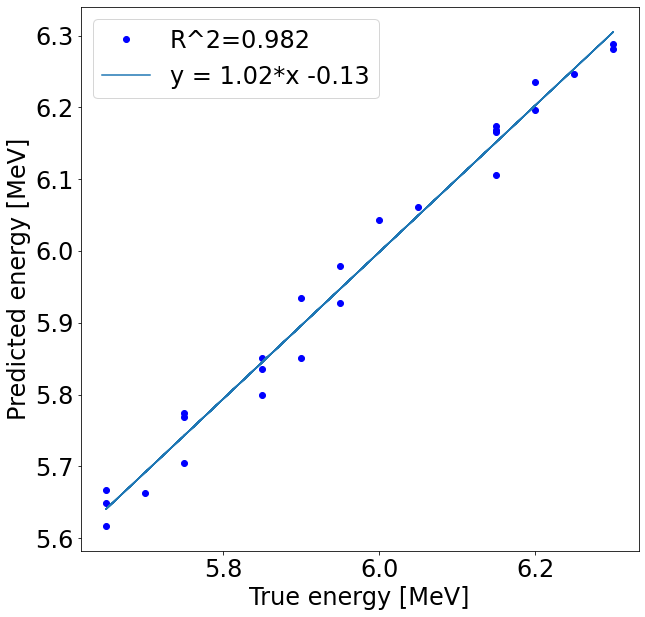

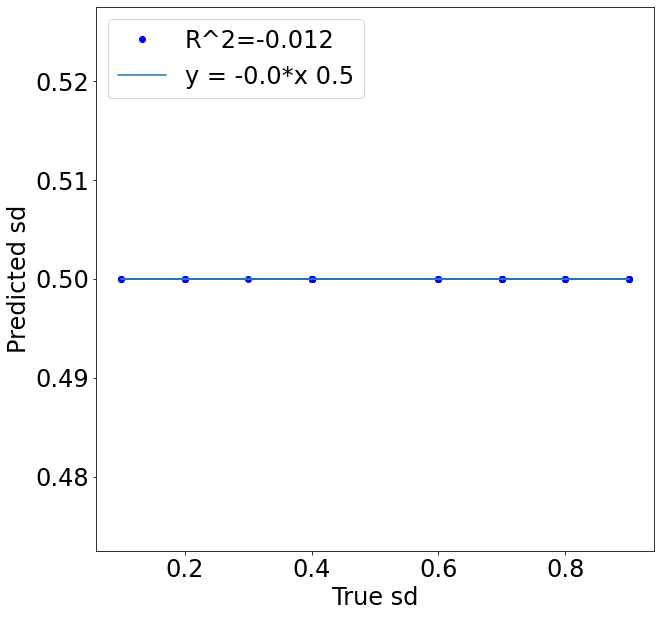

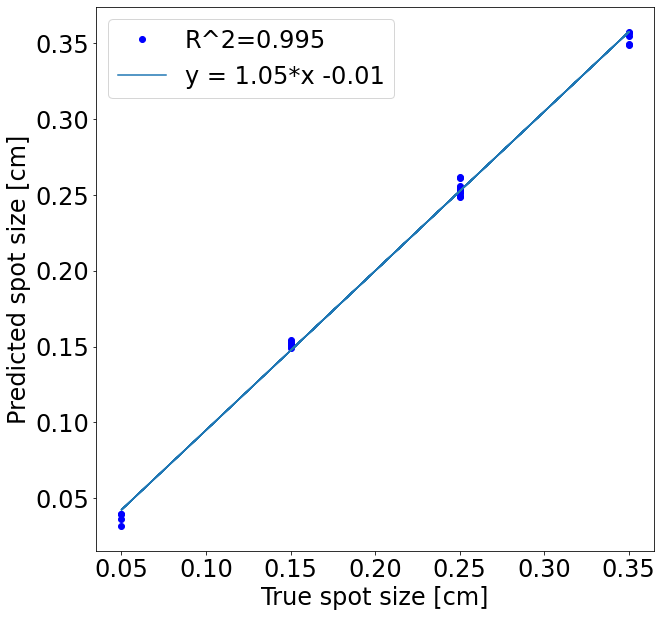

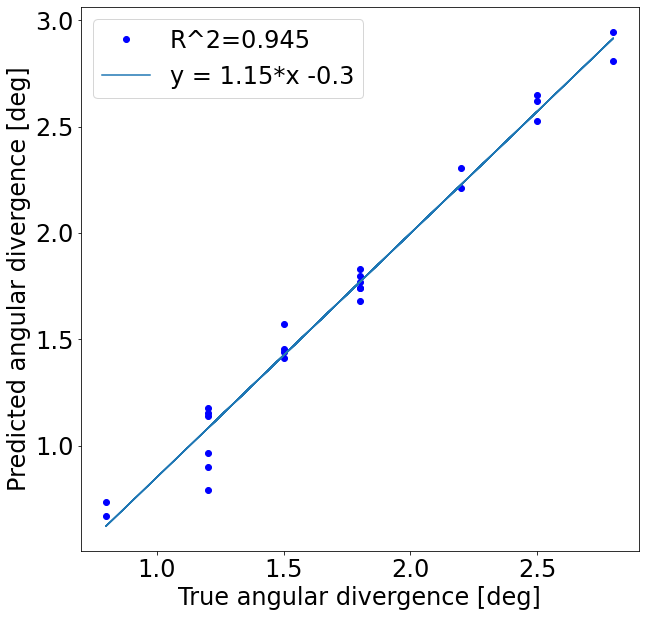

In [7]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
plt.rcParams.update({'font.size': 24})

captions = ['energy [MeV]','sd','spot size [cm]','angular divergence [deg]']

preds = []
for goal in config.trainingGoals:
    modelName = config.modelDIR + 'SVR_' + str(goal) + '_.pkl'
    clf = pickle.load(open(modelName,'rb'))

    print(clf.score(X_test,y_test[:,goal]))
    predTest = clf.predict(X_test)
    preds.append(predTest)
    
    plt.figure(figsize=(10,10))
    plt.xlabel('True ' + captions[goal])
    plt.ylabel('Predicted ' + captions[goal])
    plt.plot(y_test[:,goal],predTest,'ob',label='R^2='+str(np.round(clf.score(X_test,y_test[:,goal]),3)))
    m, b = np.polyfit(y_test[:,goal], predTest, 1)
    plt.plot(y_test[:,goal], m*y_test[:,goal] + b,label = 'y = '+str(np.round(m,2)) + '*x ' + str(np.round(b,2)) )
    plt.legend(loc='upper left')
    plt.savefig(captions[goal])


In [15]:
# Print results
for n,goal in enumerate(config.trainingGoals):
    print(captions[goal])
#    for c in range(y_test.shape[0]):
#        print(y_test[c,goal],preds[n][c])
    print(np.std(y_test[:,goal] - preds[n]))
#    print('\n')

energy [MeV]
0.02825092972373066
sd
0.25380307326744495
spot size [cm]
0.00706022867653899
angular divergence [deg]
0.1272992049823404


In [9]:
allMeans,allFieldFeatures,allFieldPCAModels = utils.allPCAResults()

[6.173317252973183, 0.5, 0.35712524087469166, 0.6717212390192873]
[5.7999211701565665, 0.5, 0.2543635000504041, 2.8091626385875292]
[5.649528719874497, 0.5, 0.2617124955120266, 2.6193826889605103]
[6.16831306230634, 0.5, 0.0316664503840631, 1.4536340419472737]
[6.280919250063758, 0.5, 0.15177631663863142, 1.1535985962817725]
[5.768565318894572, 0.5, 0.25206256371980124, 1.769000978149693]
[5.934191204688412, 0.5, 0.039660820066373975, 1.5703466240375503]
[5.836208474632356, 0.5, 0.03618633764705802, 1.679571347540765]
[5.77461538408736, 0.5, 0.1531806153576107, 2.6475376801755974]
[6.1651737068463355, 0.5, 0.2556546642462323, 1.829536854955996]
[6.247029338227264, 0.5, 0.2609968549203987, 1.1786910289937231]
[6.042571244336274, 0.5, 0.15058210829466176, 2.3070093999551657]
[6.195831661038975, 0.5, 0.35485615298620693, 2.5263283979320446]
[6.23566052627033, 0.5, 0.25338616087157023, 1.7411762679514142]
[5.66725367160853, 0.5, 0.03955567680851678, 2.9453070226535747]
[5.97846018008548, 0

/home/zbislaw/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/home/zbislaw/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/home/zbislaw/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interf

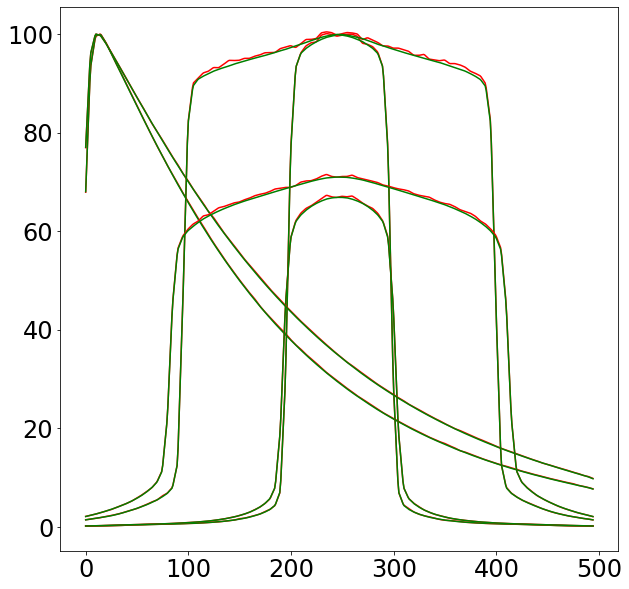

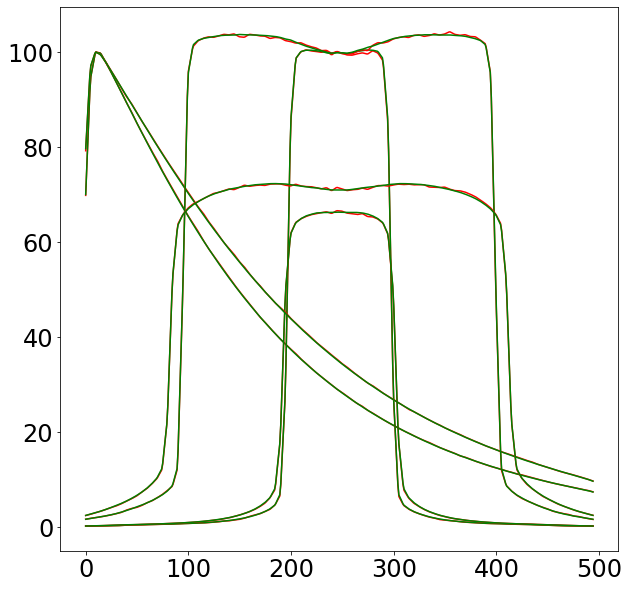

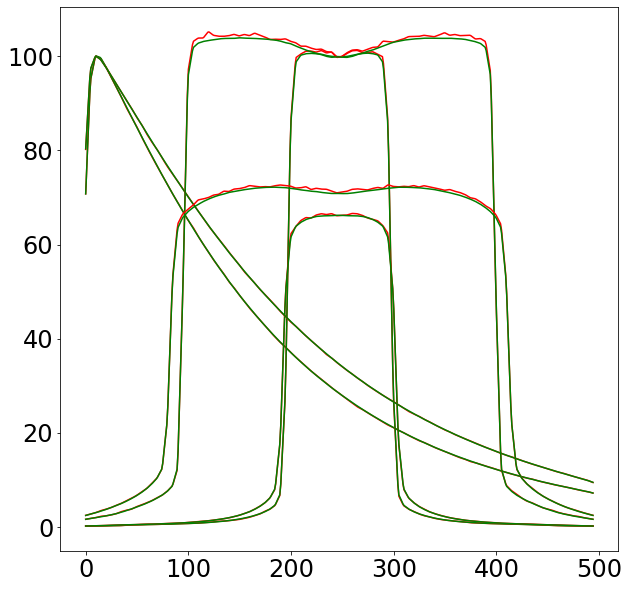

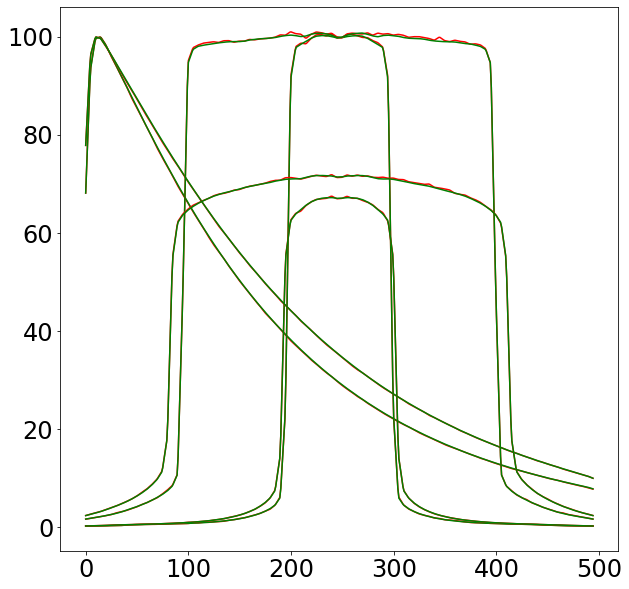

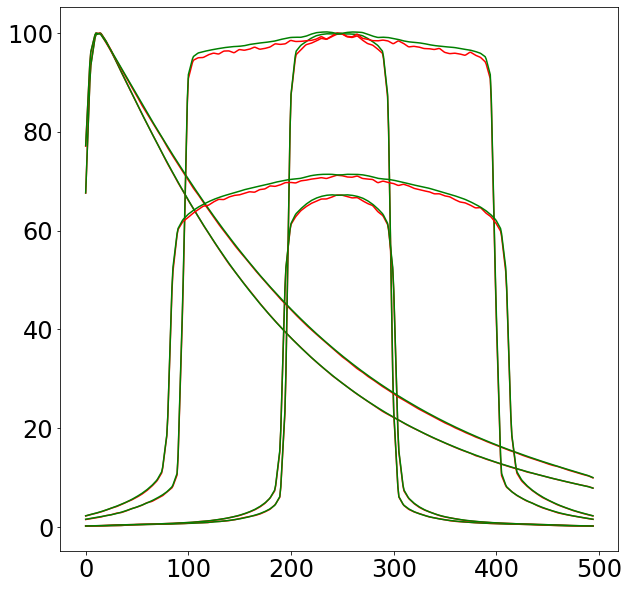

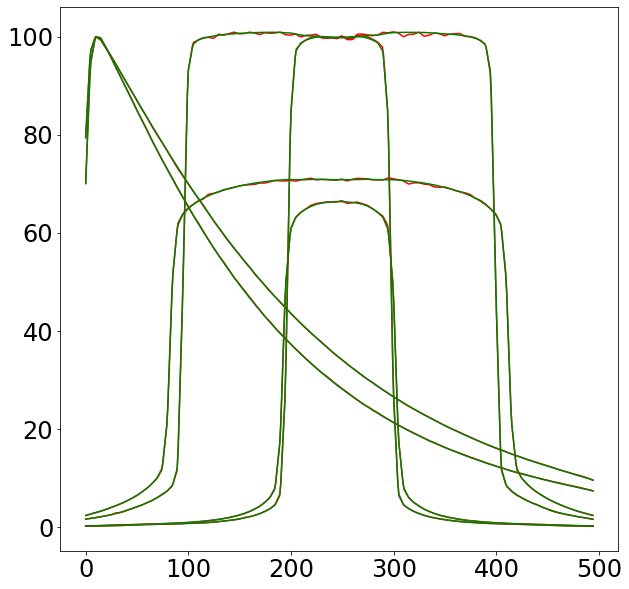

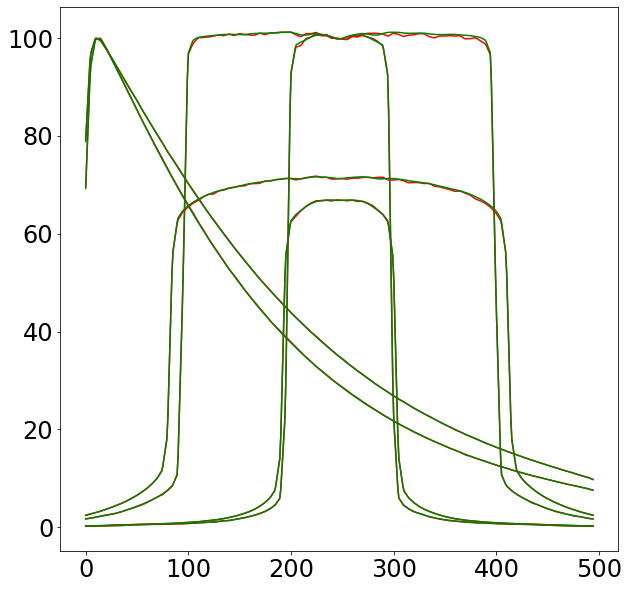

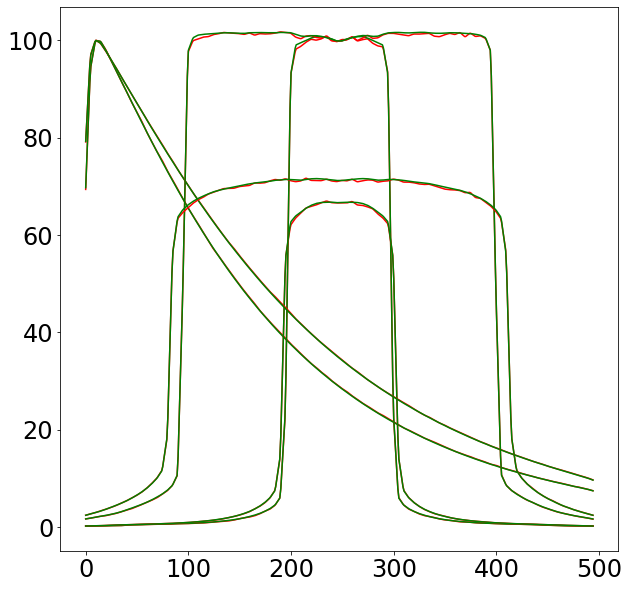

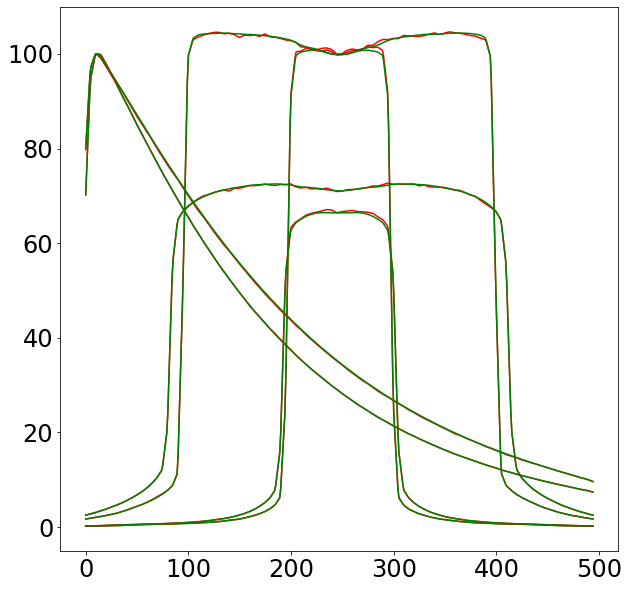

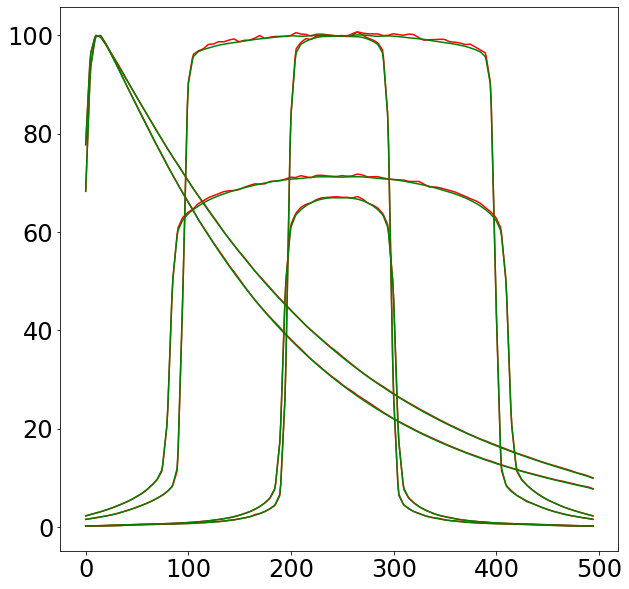

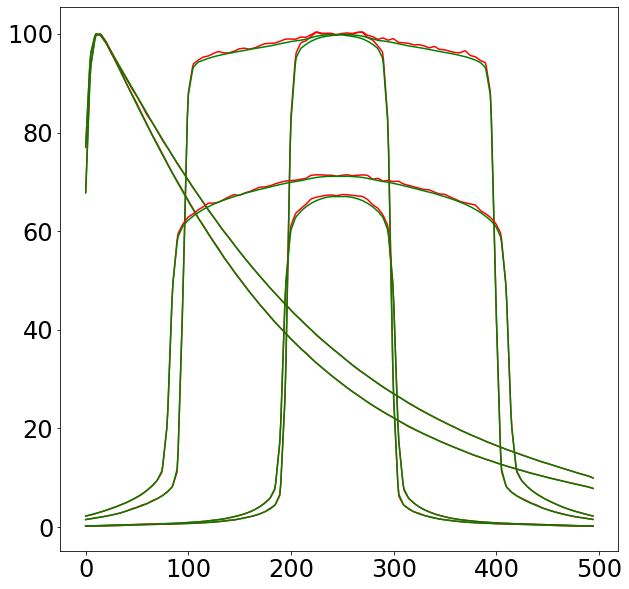

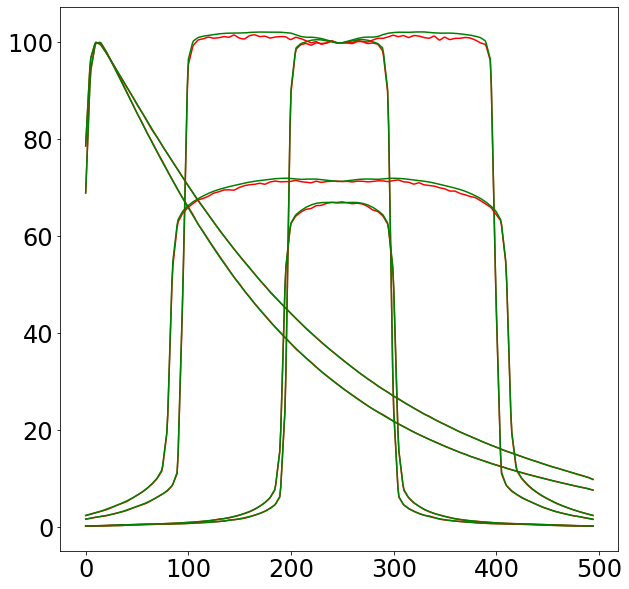

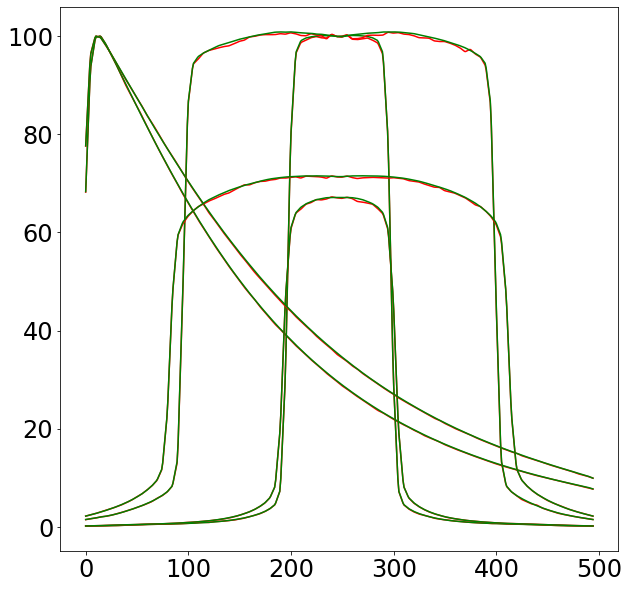

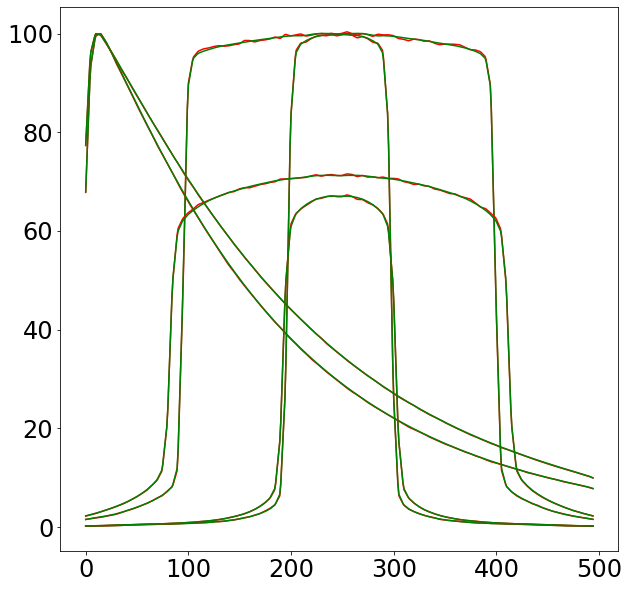

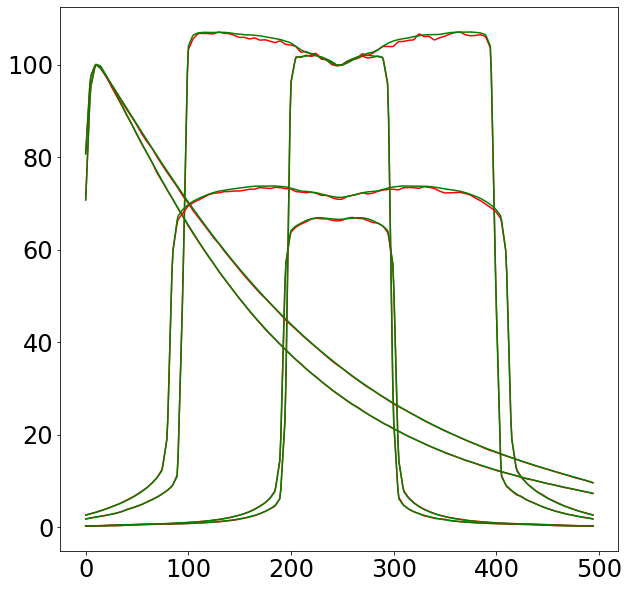

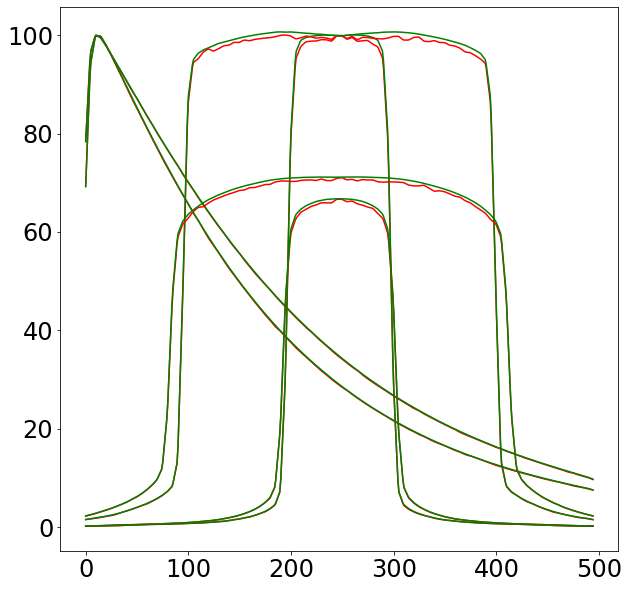

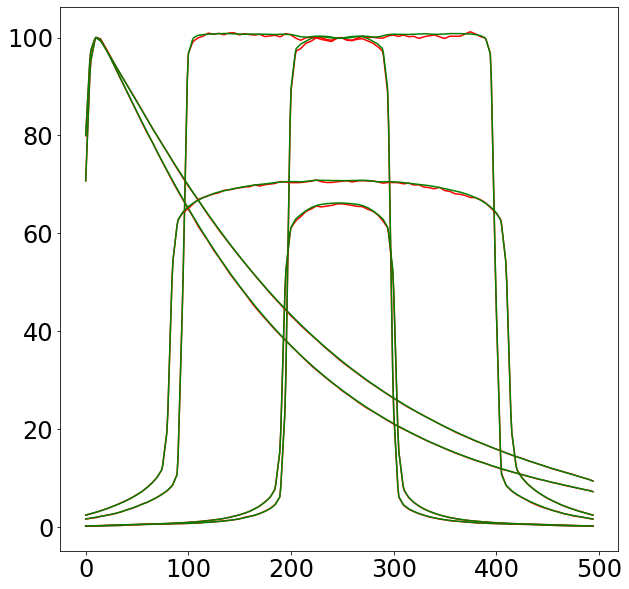

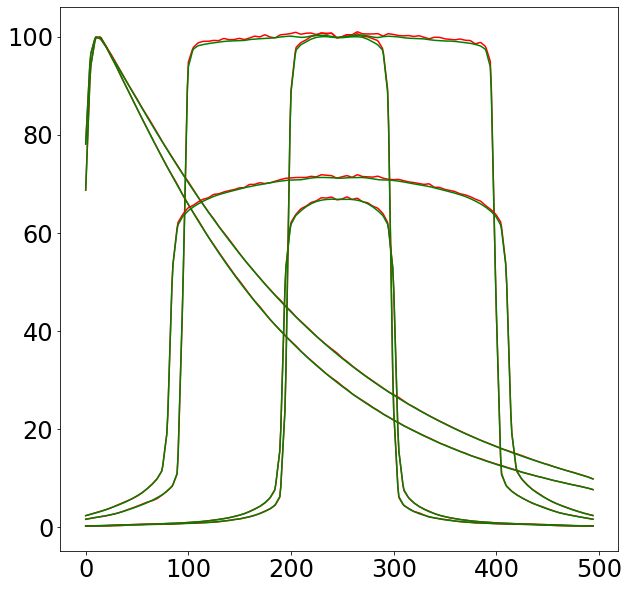

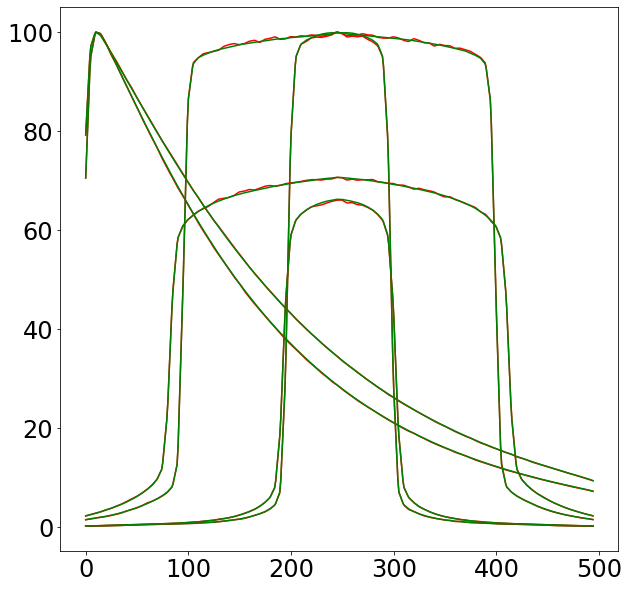

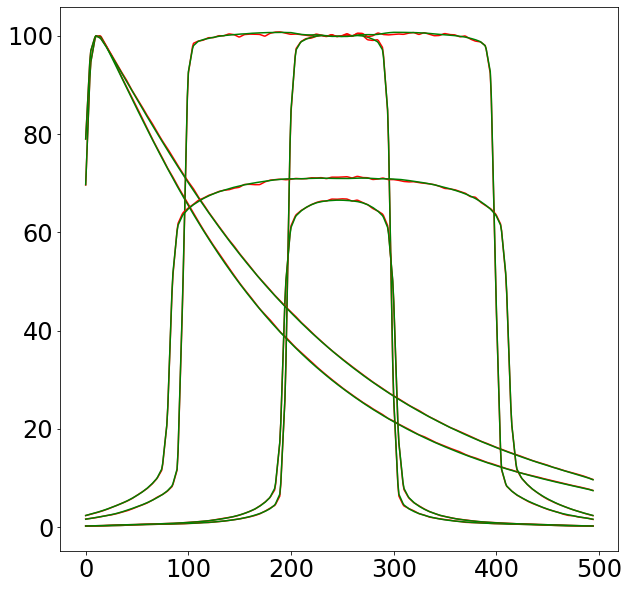

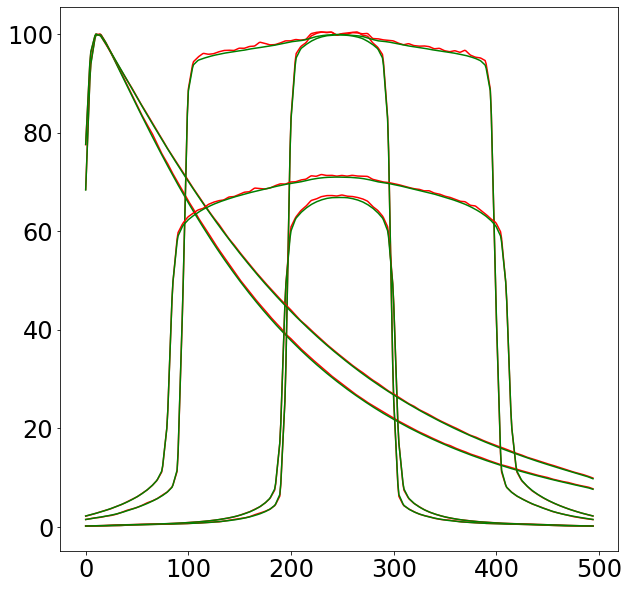

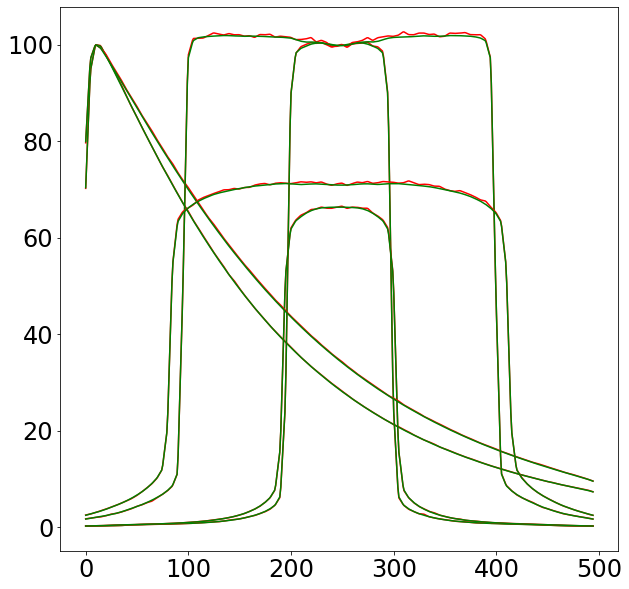

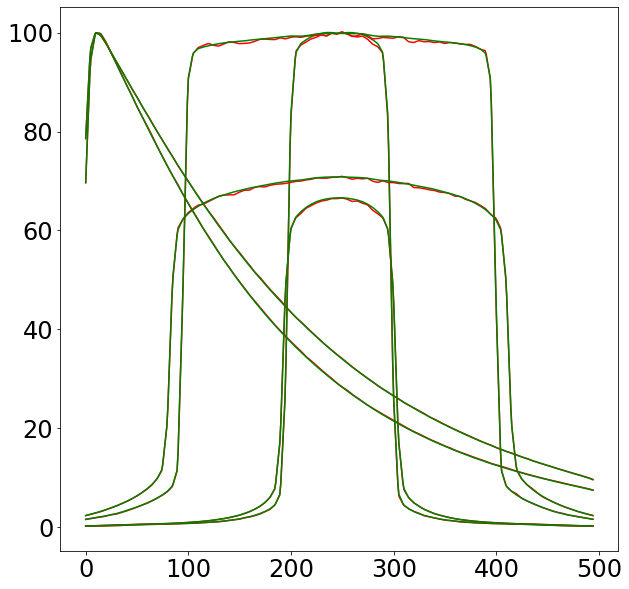

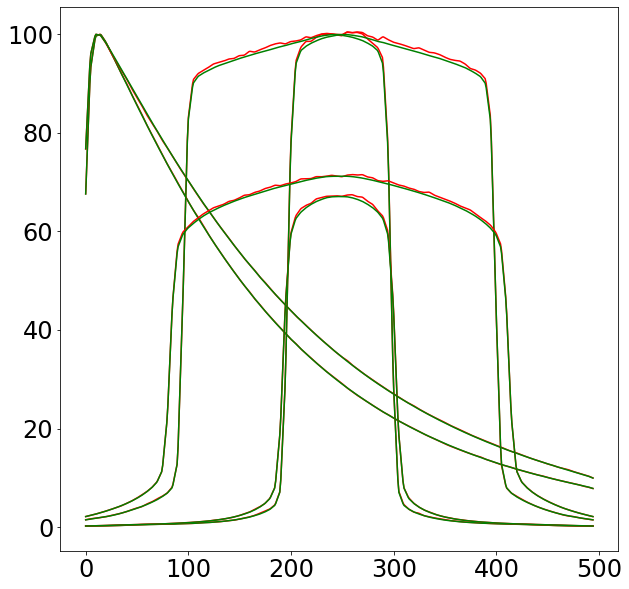

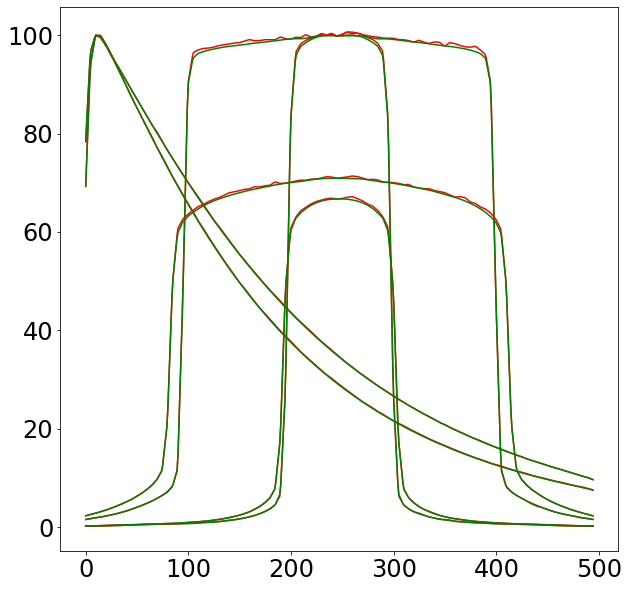

In [10]:
for p in range(preds[0].shape[0]):
    x0 = [preds[l][p] for l in range(4)]
    print(x0)
    clinicalProfiles = []
    for nfield,field in enumerate(config.analyzedProfiles):
        if field != None:
            for profile in field:
                clinicalProfiles.append(testProfiles[nfield][p][profile])
    recons = utils.reconstruct(x0,allMeans,allFieldFeatures,allFieldPCAModels)
    plt.figure(figsize = (10,10))
    for num in range(len(recons)):
        plt.plot(clinicalProfiles[num],'r-')
        plt.plot(recons[num],'g-')
    plt.show
    #break

In [12]:
import scipy.optimize as opt
from scipy.optimize import SR1

def fun(cP,aM,aF,aPCA):
    def diff(y):
        return utils.difference(y,cP,aM,aF,aPCA)
    return diff

xe = []
for p in range(preds[0].shape[0]):
    x0 = [preds[l][p] for l in range(4)]
    print(x0)

    clinicalProfiles = []
    for nfield,field in enumerate(config.analyzedProfiles):
        if field != None:
            for profile in field:
                clinicalProfiles.append(testProfiles[nfield][p][profile])

    difference = fun(clinicalProfiles,allMeans,allFieldFeatures,allFieldPCAModels)
    
    res = opt.minimize(difference, x0, method='SLSQP', jac="2-point",
                   options={'ftol': 1e-9, 'disp': True},
                   bounds=config.bounds)
    print(res.x)
    xe.append(res.x)
    

[6.173317252973183, 0.5, 0.35712524087469166, 0.6717212390192873]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 45.10637766764639
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
[6.23227223 0.5        0.35098543 1.0668137 ]
[5.7999211701565665, 0.5, 0.2543635000504041, 2.8091626385875292]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 60.04483412564562
            Iterations: 33
            Function evaluations: 249
            Gradient evaluations: 33
[5.8        0.5        0.25271886 2.79281101]
[5.649528719874497, 0.5, 0.2617124955120266, 2.6193826889605103]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 111.02450808394343
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
[5.63971416 0.5        0.25134912 2.80497205]
[6.16831306230634, 0.5, 0.031666450384

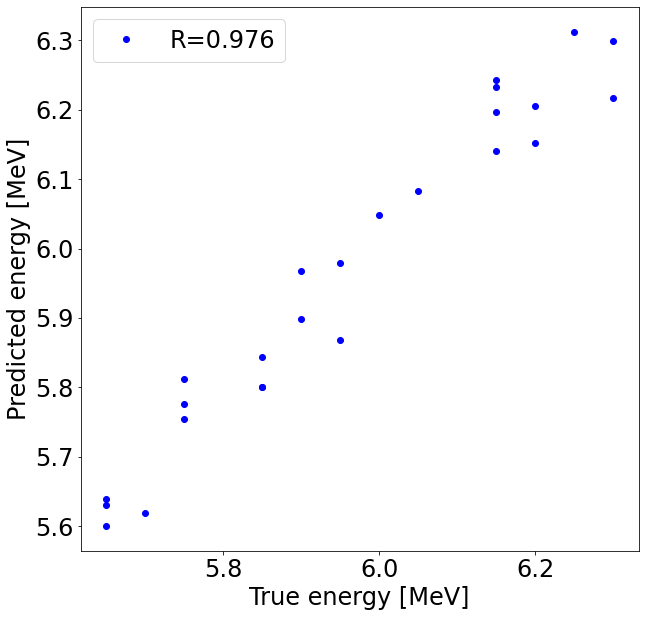

/home/zbislaw/anaconda3/envs/DL/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


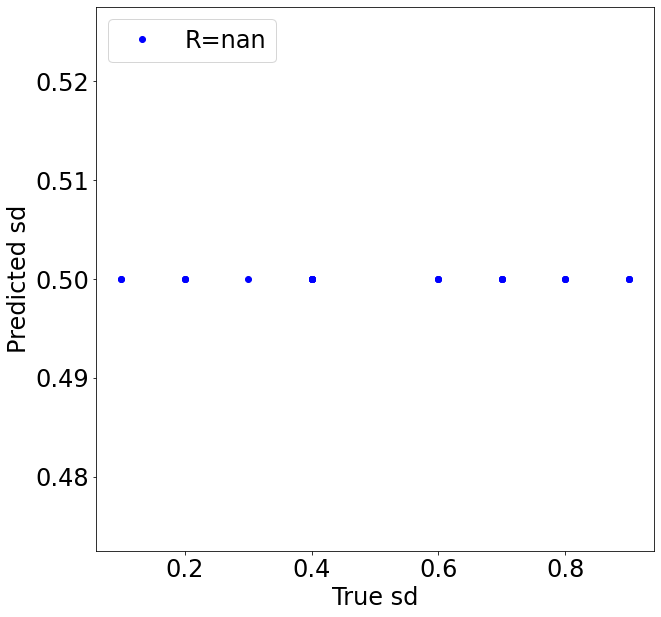

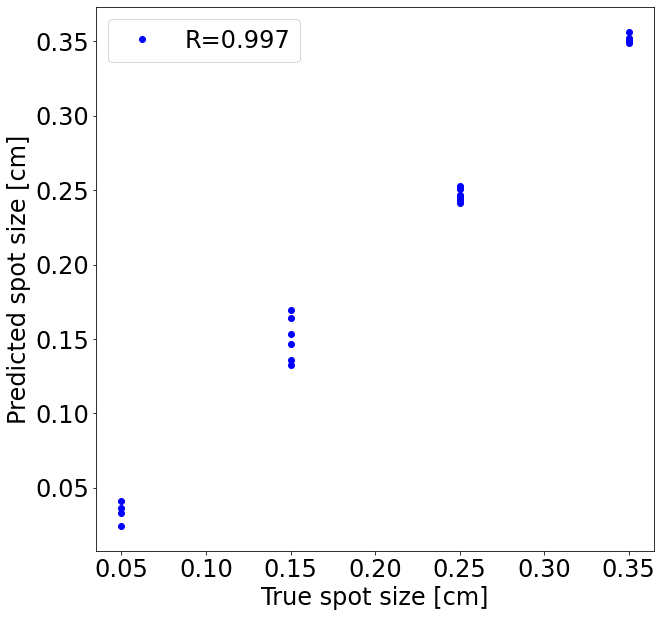

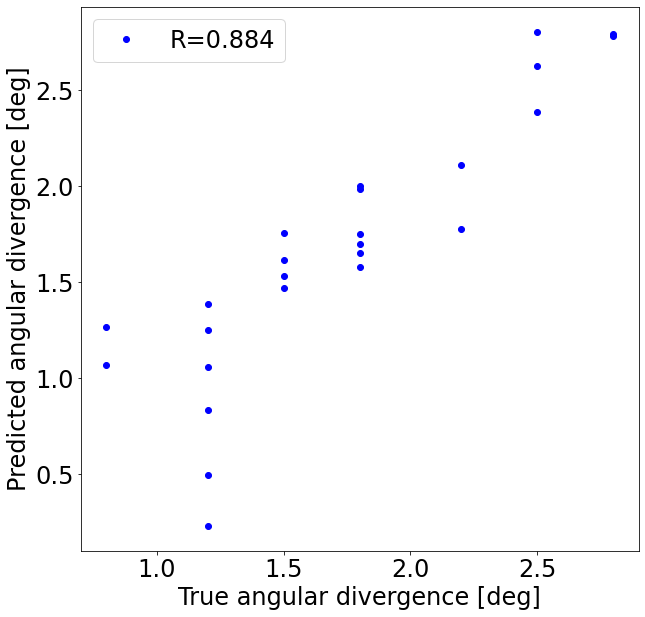

In [13]:
from scipy.stats import pearsonr

#print(np.asarray(xe).shape)
#print(y_test.shape)

for goal in range(4):
    plt.figure(figsize=(10,10))
    plt.xlabel('True ' + captions[goal]) 
    plt.ylabel('Predicted ' + captions[goal])
    corr, _ = pearsonr(y_test[:,goal], np.asarray(xe)[:,goal])
    plt.plot(y_test[:,goal],np.asarray(xe)[:,goal],'ob',label='R='+str(np.round(corr,3)))
    plt.legend(loc='upper left')
    plt.show()

